# Приложение: рекомендательные системы

### Что дано?

- Матрица пользователь-продукт
- Элементы матрицы – рейтинги, если есть
- Неполное заполнение

## Как использовать SVD?

- Оригинальная работа [*Performance of recommender algorithms on top-n recommendation tasks*](https://dl.acm.org/citation.cfm?id=1864721), Cremonesi, P., Koren, Y., and Turrin, R
- Построим вложение пользователей и продуктов в некоторое подпространство $\mathbb{R}^n$
- Для известных предпочтений найдём наиболее близкие продукты в этом подпространстве
- Как это вычислительно сделать?

### Датасет Movielens с рейтингами фильмов

In [3]:
import pandas as pd
movies = pd.read_csv('movies.gz', index_col='movieid', header=0, encoding='unicode-escape')[['movienm', 'genreid']]
ratings = pd.read_csv('ratings.gz', header=0)

### Пример записей

In [4]:
movies.head()

,movienm,genreid
movieid,,
1,Toy Story (1995),"Animation, Children's, Comedy"
2,Jumanji (1995),"Adventure, Children's, Fantasy"
3,Grumpier Old Men (1995),"Comedy, Romance"
4,Waiting to Exhale (1995),"Comedy, Drama"
5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [6]:
ratings[['userid', 'movieid']].apply(pd.Series.nunique)

userid     6040
movieid    3706
dtype: int64

### Зададим список предпочтений

In [9]:
best_movies = "Terminator"
target_movies = movies.loc[movies.movienm.str.contains(best_movies, flags=2)]
target_movies

,movienm,genreid
movieid,,
589,Terminator 2: Judgment Day (1991),"Action, Sci-Fi, Thriller"
1240,"Terminator, The (1984)","Action, Sci-Fi, Thriller"


### Выделим индексы выбранных фильмов

In [10]:
favorite_movies_ids = target_movies.index
print(favorite_movies_ids)

Int64Index([589, 1240], dtype='int64', name='movieid')


### Создадим матрицу с рейтингами 

In [12]:
import scipy.sparse as spsp
data_matrix = spsp.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userid.values, ratings.movieid.values)))
print(data_matrix.shape)

(6041, 3953)


### Вычислим SVD

In [28]:
rank = 100
import scipy.sparse.linalg as spsplin
_, S, Vt = spsplin.svds(data_matrix, k=rank, return_singular_vectors='vh')
print(Vt.shape)
print(S[0] / S[-1])

(100, 3953)
0.06357782341127233


### Посмотрим на убывание сингулярных чисел

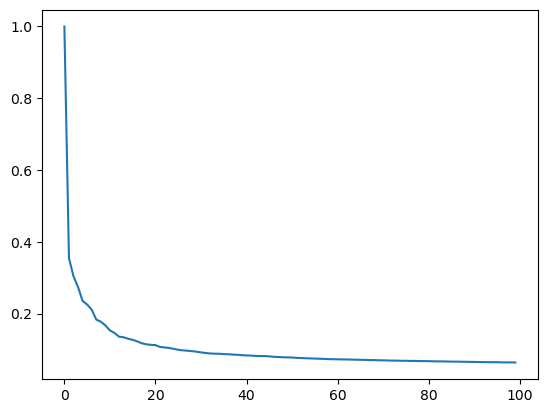

In [22]:
import matplotlib.pyplot as plt
plt.plot(S[::-1] / S[-1])

### Получим корреляции

In [23]:
print(Vt[:, favorite_movies_ids].shape)
correlation = Vt.T @ Vt[:, favorite_movies_ids]
print(correlation.shape)
score = correlation.sum(axis=1)
print(score.shape)
# movies.loc[np.argsort(-Vt.T @ Vt[:, favorite_movies_ids].sum(axis=1))[:15]] # assuming binary preference vector

(100, 2)
(3953, 2)
(3953,)


### Вычислим итоговые рекомендации

In [24]:
import numpy as np
top_n = 20
print(np.sort(score)[::-1][:top_n])
movies.loc[np.argsort(-score)[:top_n]]

[0.48776358 0.39956492 0.21780138 0.19979763 0.17251055 0.15647883
 0.15086257 0.10614735 0.08942975 0.08613985 0.08369481 0.07686736
 0.07522329 0.06974001 0.0614942  0.0567281  0.0534383  0.0487753
 0.04722116 0.04501783]


,movienm,genreid
movieid,,
589,Terminator 2: Judgment Day (1991),"Action, Sci-Fi, Thriller"
1240,"Terminator, The (1984)","Action, Sci-Fi, Thriller"
2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller"
1200,Aliens (1986),"Action, Sci-Fi, Thriller, War"
2916,Total Recall (1990),"Action, Adventure, Sci-Fi, Thriller"
1214,Alien (1979),"Action, Horror, Sci-Fi, Thriller"
1036,Die Hard (1988),"Action, Thriller"
3527,Predator (1987),"Action, Sci-Fi, Thriller"
908,North by Northwest (1959),"Drama, Thriller"


### Обобщения 

- Учёт контекста позволяет внести в скалярное произведение матрицу похожести. Получим гибридную модель SVD, подробности в [этой работе](https://arxiv.org/pdf/1802.06398.pdf)
- Обзор использования нейронных сетей в рекомендательных системах можно найти [тут](https://arxiv.org/pdf/1707.07435.pdf): неочевидные преимущества по сравнению с моделями, основанными на матричных разложениях